In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
from PIL import Image
from tqdm import tqdm
import time

from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers

In [2]:
def dataLoader(root_dir):
    fnames = os.listdir(root_dir)
    data = np.zeros([len(fnames), 256, 256, 3])
    for i in tqdm(range(len(fnames)), ncols=70):
        fname = fnames[i]
        path = os.path.join(root_dir, fname)
        data[i, :, :, :] = cv2.resize(cv2.imread(path), (256, 256)) / 255.0
    data = data.astype(np.float32)
    
    return data

def gram_matrix(input_tensor):
    '''
        Sum_{i, j}(F_{bijc} * F_{bijd})
    G = -------------------------------,   b = batch,  i,j = position,  c,d = feature maps generating from different filters
                    I * J
    '''
    temp = tf.linalg.einsum('bijc, bijd -> bcd', input_tensor, input_tensor)
    numer = tf.expand_dims(temp, axis=0)
    input_shape = input_tensor.shape
    denom = tf.cast(input_shape[1] * input_shape[2] * input_shape[3], tf.float32)

    return numer / denom

def getLossNet(input_shape=(256, 256, 3)):
    vgg16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    #vgg16.load_weights('./vgg16_weights_tf_dim_ordering_tf_kernels.h5')
    vgg16.trainable = False
    out_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']
    content_output = vgg16.get_layer(out_layers[1]).output
    style_output = [vgg16.get_layer(out_layer).output for out_layer in out_layers]
    gram_style_output = [gram_matrix(output_) for output_ in style_output]
    model = Model([vgg16.input], [content_output, gram_style_output])

    return model

In [3]:
class TransNet:
    
    def __init__(self, feat_weight=3, style_weight=1e4, tv_weight=1e-5, 
                 style_image=None, lossNet=tf.keras.Model(), 
                 opt=tf.optimizers.Adam(learning_rate=0.00005)):
        # ===================== Build the transform image net =======================
        def resBlock(x, n_filters, kernel_size):
            fx = layers.Conv2D(n_filters, kernel_size, padding='same')(x)
            fx = layers.BatchNormalization()(fx)
            fx = layers.ReLU()(fx)
            fx = layers.Conv2D(n_filters, kernel_size, padding='same')(fx)
            fx = layers.BatchNormalization()(fx)
            out = layers.Add()([x, fx])
            out = layers.ReLU()(out)

            return out
        
        x = tf.keras.Input(shape=(256, 256, 3))
        fx = layers.Conv2D(32, (9, 9), padding='same')(x)
        fx = layers.BatchNormalization()(fx)
        fx = layers.ReLU()(fx)
        fx = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(fx)
        fx = layers.BatchNormalization()(fx)
        fx = layers.ReLU()(fx)
        fx = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(fx)
        fx = layers.BatchNormalization()(fx)
        fx = layers.ReLU()(fx)

        for _ in range(5):
            fx = resBlock(fx, 128, (3, 3))

        fx = layers.Conv2D(64, (3, 3), padding='same')(fx)
        fx = layers.UpSampling2D(size=(2,2), interpolation='nearest')(fx)
        fx = layers.BatchNormalization()(fx)
        fx = layers.ReLU()(fx)
        fx = layers.Conv2D(32, (3, 3), padding='same')(fx)
        fx = layers.UpSampling2D(size=(2,2), interpolation='nearest')(fx)
        fx = layers.BatchNormalization()(fx)
        fx = layers.ReLU()(fx)
        out = layers.Conv2D(3, (9, 9), padding='same')(fx)
        #out = layers.BatchNormalization()(out)
        out = layers.ReLU()(out)
        #out = layers.Activation('sigmoid')(out)
        
        self.model = Model([x], [out])
        # ==========================================================================
        
        self.opt = opt
        self.lossNet = lossNet
        self.style_target = self.lossNet(np.array([style_image]))[1]
        self.feat_weight = feat_weight
        self.style_weight = style_weight
        self.tv_weight = tv_weight
        self.losses = []
    
    def compute_loss(self, style_output, content_output, content_target, output_image):
        #feature_loss = mse(content_target, content_output).numpy()
        feature_loss = tf.reduce_mean((content_output - content_target)**2)
        style_loss = tf.add_n([tf.reduce_mean((output_ - target_)**2) for output_, target_ in zip(style_output, self.style_target)])
        #style_loss = tf.reduce_mean([tf.norm(output_ - target_, ord='fro', axis=[-2,-1]).numpy()**2 for output_, target_ in zip(style_output, style_target)])
        total_var = tf.reduce_mean(tf.image.total_variation(output_image))
        loss = self.feat_weight * feature_loss + self.style_weight * style_loss + self.tv_weight * total_var
        
        return loss, float(self.feat_weight * feature_loss), float(self.style_weight * style_loss), float(self.tv_weight * total_var)
    
    def train(self, image, content_target, epoch, it):
        with tf.GradientTape() as tape:
            output_image = tf.clip_by_value(self.model(image), clip_value_min=0.0, clip_value_max=1.0)
            output_loss = self.lossNet(output_image)
            loss, _, _, _ = self.compute_loss(output_loss[1], output_loss[0], content_target, output_image)
        gradient = tape.gradient(loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(gradient, self.model.trainable_variables))

        self.losses.append(loss)
        
        if it % 1000 == 0: 
            tf.print(f'Epoch = {epoch}, Iteration = {it}, Loss = {loss}')
        
    def stylize(self, image):
        if image.ndim < 4: 
            image = tf.expand_dims(image, axis=0)
        
        start = time.time()
        pred = tf.clip_by_value(self.model(image), clip_value_min=0.0, clip_value_max=1.0)
        end = time.time()
        
        tensor = pred * 255
        tensor = np.array(tensor, dtype=np.uint8)
        if np.ndim(tensor) > 3: 
            assert tensor.shape[0] == 1
            tensor = tensor[0]
        tensor = Image.fromarray(tensor)
        
        plt.subplots(figsize=(14,4))
        plt.subplot(1, 2, 1)
        out_img = cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB)
        plt.imshow(out_img)
        plt.subplot(1, 2, 2)
        plt.plot(self.losses)
        plt.show()
        
        return out_img, np.float16((end - start) * 1000)

100%|██████████████████████████| 40670/40670 [03:09<00:00, 214.86it/s]


Epoch = 0, Iteration = 0, Loss = 300.3369140625
Epoch = 0, Iteration = 1000, Loss = 48.477657318115234
Epoch = 0, Iteration = 2000, Loss = 41.59202194213867
Epoch = 0, Iteration = 3000, Loss = 39.98591232299805
Epoch = 0, Iteration = 4000, Loss = 34.40977096557617
Epoch = 0, Iteration = 5000, Loss = 43.07560348510742
Epoch = 1, Iteration = 0, Loss = 44.0281982421875
Epoch = 1, Iteration = 1000, Loss = 37.82432556152344
Epoch = 1, Iteration = 2000, Loss = 40.371578216552734
Epoch = 1, Iteration = 3000, Loss = 32.024879455566406
Epoch = 1, Iteration = 4000, Loss = 28.502025604248047
Epoch = 1, Iteration = 5000, Loss = 35.893043518066406
Final loss = 34.4713134765625, Time cost = 3018.0 s


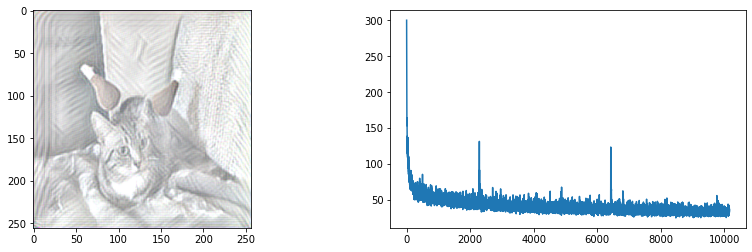

Time cost for stylizing one image = 205.625 ms


C:\Users\kimiz\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [4]:
def main():
    # parameters
    epochs = 2
    batch_size = 8

    # training data
    root_dir = './test2017'
    data = dataLoader(root_dir)

    # style reference
    style_image = cv2.resize(cv2.imread('./styles/sumiao.png'), (256, 256))
    style_image = tf.image.convert_image_dtype(style_image, tf.float32)

    # optimizer and loss net
    optimizer = tf.optimizers.Adam(learning_rate=0.00005)
    lossNet = getLossNet()

    # image transform net
    transNet = TransNet(style_image=style_image, lossNet=lossNet, opt=optimizer)

    # train
    start = time.time()
    for epoch in range(epochs):
        # shuffling
        data_index = np.arange(data.shape[0])
        np.random.shuffle(data_index)
        data = data[data_index]

        for it in range(data.shape[0] // batch_size):
            content_image = data[it * batch_size: it * batch_size + batch_size]
            if content_image.ndim < 4: 
                content_image = tf.expand_dims(content_image, axis=0)

            content_target = lossNet(np.array(content_image))[0]   
            transNet.train(content_image, content_target, epoch, it)

    end = time.time()

    tf.print(f'Final loss = {transNet.losses[-1]}, Time cost = {np.float16((end - start))} s')
    
    
    # test
    test_image = cv2.resize(cv2.imread('./images/cat.jpg'), (256, 256))
    test_image = tf.image.convert_image_dtype(test_image, tf.float32)
    out_img, t = transNet.stylize(test_image)
    tf.print(f'Time cost for stylizing one image = {t} ms')
    #image_big = cv2.resize(out_img, (1080, 1080), interpolation=cv2.INTER_CUBIC)
    #plt.imshow(image_big)
    
    # save model
    transNet.model.save('./trained/fast_neural_style_transfer.h5')

if __name__ == "__main__":
    main()